In [ ]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/rnn"
downloads = {"surnames_with_splits.csv": None,
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# Generating Surnames with a RNN

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from nlp import Vocabulary, StepByStep, allclose, mdprint

# 1 Data preparation

This code reads a CSV file named `"surnames_with_splits.csv"` into a DataFrame using pandas. It then splits the DataFrame into three subsets based on the value in the `split` column: 

- `train_df`: Contains rows where the `split` column equals `"train"`.
- `val_df`: Contains rows where the `split` column equals `"val"`.
- `test_df`: Contains rows where the `split` column equals `"test"`.

Finally, it displays the `train_df` DataFrame, which contains the training data.

In [3]:
surname_df = pd.read_csv("surnames_with_splits.csv")

train_df = surname_df[surname_df.split == "train"]
val_df = surname_df[surname_df.split == "val"]
test_df = surname_df[surname_df.split == "test"]

## 1.1 Maximal Size

👍  
In this task, you need to implement a function called `get_max_length` that accepts a sequence (such as a list or array) and returns the length of the longest item in the sequence.
- Define the function `get_max_length(sequence)` that takes a sequence as input.
- The function should return the length of the longest item in the sequence.


In [4]:
def get_max_length(sequence):
    return max(len(item) for item in sequence)

max_surname_size = get_max_length(train_df.surname)
print(max_surname_size)

assert max_surname_size == 17

17


## 1.3 Building Vocabulary

This code initializes two vocabularies, `surname_vocab` and `nationality_vocab`, using a custom `Vocabulary` class.

- `PAD_TOK` is set to a space (`" "`) and `UNK_TOK` is set to an "@" symbol, which are used as special tokens for padding and unknown words, respectively.
- `surname_vocab` is created with these special tokens, and then the vocabulary is populated using the `fill()` method, which is called on the `surname` column from the `train_df` DataFrame.
- `nationality_vocab` is created without any special tokens, and its vocabulary is populated with the unique nationalities from `train_df`, sorted by their frequency (from `nationality_counts`).

Finally, it prints the contents of both `surname_vocab` and `nationality_vocab` to the console.

In [5]:
PAD_TOK = " "
BGN_TOK = "<"
END_TOK = ">"
UNK_TOK = "@"

surname_vocab = Vocabulary(pad_tok=PAD_TOK, bgn_tok=BGN_TOK, end_tok=END_TOK, unk_tok=UNK_TOK)
surname_vocab.fill(train_df.surname)

nationality_vocab = Vocabulary()
nationality_vocab.fill([sorted(set(train_df.nationality))])

print(f"Surname vocab: {surname_vocab}")
print(f"Nationality vocab: {nationality_vocab}")

Surname vocab: {' ': 0, '<': 1, '>': 2, '@': 3, 'T': 4, 'o': 5, 't': 6, 'a': 7, 'h': 8, 'A': 9, 'b': 10, 'u': 11, 'd': 12, 'F': 13, 'k': 14, 'r': 15, 'y': 16, 'S': 17, 'e': 18, 'g': 19, 'C': 20, 'm': 21, 'H': 22, 'i': 23, 'K': 24, 'n': 25, 'W': 26, 's': 27, 'f': 28, 'G': 29, 'M': 30, 'l': 31, 'B': 32, 'z': 33, 'N': 34, 'I': 35, 'w': 36, 'D': 37, 'Q': 38, 'j': 39, 'E': 40, 'R': 41, 'Z': 42, 'c': 43, 'Y': 44, 'J': 45, 'L': 46, 'O': 47, '-': 48, 'P': 49, 'X': 50, 'p': 51, ':': 52, 'v': 53, 'U': 54, '1': 55, 'V': 56, 'x': 57, 'q': 58, 'é': 59, 'É': 60, "'": 61, 'ß': 62, 'ö': 63, 'ä': 64, 'ü': 65, 'ú': 66, 'à': 67, 'ò': 68, 'è': 69, 'ó': 70, 'Ś': 71, 'ą': 72, 'ń': 73, 'á': 74, 'ż': 75, 'õ': 76, 'í': 77, 'ñ': 78, 'Á': 79}
Nationality vocab: {'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}

## 1.6 Surname Vectorization

👍  
In this task, you need to implement a function called `vectorize` that converts a sequence (such as a string) into a fixed-size tensor of integers, based on the provided vocabulary. It optionally adds special markers for the beginning and end of the sequence and handles truncation or padding to ensure the output tensor matches the desired size.

- Define the function `vectorize(sequence, vocab, max_size, mark_sequence=True)` that takes three inputs:
  - `sequence`: A sequence (such as a string) to be vectorized.
  - `vocab`: A dictionary mapping items in the sequence to integer indices.
  - `max_size`: The maximum size of the output tensor.
  - `mark_sequece`: If `True`, the function adds "begin of sequence" token at the start and "end of token" at the end of the sequence.
- The function should return a tensor of size `max_size` (if `mark_sequence` is set to `False` or `max_size + 2` otherwise), where:
  - Each position in the tensor corresponds to an index from the `vocab` for the corresponding item in the sequence.
  - The sequence is truncated or padded to fit the `max_size`.
  - Begin of sequence token and end of sequence token are accessible through vocabulary using `vocab.bgn_tok` and `vocab.end_tok`.


In [6]:
def vectorize(seq, vocab, max_size, mark_sequence=True):
    seq = list(seq)[:max_size]
    if mark_sequence:
        seq = [vocab.bgn_tok] + seq + [vocab.end_tok]
        vec = torch.zeros(max_size + 2, dtype=int)
    else:
        seq = list(seq)
        vec = torch.zeros(max_size, dtype=int)

    for i, item in enumerate(seq):
        vec[i] = vocab[item]
    return vec


sn = "Doe"
max_size = 10
# mark_sequence = True
sn2vec = vectorize(sn, surname_vocab, max_size)
assert isinstance(sn2vec, torch.Tensor) and sn2vec.dtype == torch.int64, \
    f"vectorize('{sn}', max_size={max_size}) should return tensor containing integers"
assert sn2vec.shape == (max_size + 2,), \
    f"return tensor of vectorize('{sn}', max_size={max_size}) shuld be of shape {(max_size+2, )}"
mdprint(f"Vectorization of '{sn}' with sequence marks is", sn2vec)
vec2sn = "".join([surname_vocab.inverse[idx.item()] for idx in sn2vec])
unsn = ("<" + sn + ">").ljust(max_size + 2, " ")
assert vec2sn == unsn, \
    f"Unvectorization of returned tensor of vectorize('{sn}', max_size={max_size}) must be '{unsn}'"

# mark_sequence = False
sn2vec = vectorize(sn, surname_vocab, max_size, mark_sequence=False)
assert isinstance(sn2vec, torch.Tensor) and sn2vec.dtype == torch.int64, \
    f"vectorize('{sn}', max_size={max_size}) should return tensor containing integers"
assert sn2vec.shape == (max_size,), \
    f"return tensor of vectorize('{sn}', max_size={max_size}) shuld be of shape {(max_size, )}"
mdprint(f"Vectorization of '{sn}' without sequence marks is", sn2vec)
vec2sn = "".join([surname_vocab.inverse[idx.item()] for idx in sn2vec])
unsn = sn.ljust(max_size, " ")
assert vec2sn == unsn, \
    f"Unvectorization of returned tensor of vectorize('{sn}', max_size={max_size}) must be '{unsn}'"



Vectorization of 'Doe' with sequence marks is $\begin{bmatrix} 1 & 37 & 5 & 18 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}$

Vectorization of 'Doe' without sequence marks is $\begin{bmatrix} 37 & 5 & 18 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}$

## 1.7 Datasets

This code defines a custom `Dataset` class, `SurnameDataset`, which is used for handling surname and nationality data in a format suitable for machine learning models. Dataset contains datapoints in following form: 
* x - tensor for padded and marked surname, for example `<Smith>     `
* h - tensor for nationality used as context vector
* y - tensor for shifted padded and marked surname for one letter, for example `Smith>      `


In [7]:
class SurnameDataset(Dataset):

    def __init__(self, df, surname_vocab, nationality_vocab, max_surname_size):
        self.data = []
        y_pad = torch.tensor([surname_vocab.pad_idx])
        for _, row in df.iterrows():
            x = vectorize(row.surname, surname_vocab, max_surname_size, mark_sequence=True)
            h = nationality_vocab[row.nationality]
            y = torch.cat([x[1:], y_pad])

            self.data.append((x, h, y))

    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)
    
train_dataset = SurnameDataset(train_df, surname_vocab, nationality_vocab, max_surname_size)
val_dataset = SurnameDataset(val_df, surname_vocab, nationality_vocab, max_surname_size)
test_dataset = SurnameDataset(test_df, surname_vocab, nationality_vocab, max_surname_size)

train_dataset[0]


(tensor([1, 4, 5, 6, 7, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0,
 tensor([4, 5, 6, 7, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# 2 Model

## 2.1 Model initialization

👍  
In this task, you will implement the `__init__` method of the `SurnameGeneratorRNN` class. This class defines a Recurrent Neural Network (RNN) for surname generation. The model predicts the next character in a surname sequence, given the previous characters and the nationality context. The model includes:
* Character embedding for input surnames.
* Nationality embedding for providing context.
* An RNN layer for sequence modeling.
* A fully connected layer for predicting the next character.
* Dropout for regularization.


#### **1. Input Character Embedding (`self.in_embedding`)**
- Create an `nn.Embedding` layer for character inputs:
  - **`num_embeddings`**: `len(surname_vocab)` — number of unique characters in the vocabulary.
  - **`embedding_dim`**: `in_embedding_dim` — size of the embedding vector for each character.
  - **`padding_idx`**: `surname_vocab.pad_idx` — the index used for padding.

The embedding layer maps input indices to dense vectors:
$$
\mathbf{x}_t \in \mathbb{R}^{\text{in\_embedding\_dim}}
$$
Where:
- $\mathbf{x}_t$ is the embedding for the $t$-th character in the input sequence.

---

#### **2. Nationality Embedding (`self.h_embedding`)**
- Create an `nn.Embedding` layer for nationality inputs:
  - **`num_embeddings`**: `len(nationality_vocab)` — number of nationalities.
  - **`embedding_dim`**: `h_embedding_dim` — size of the embedding vector for each nationality.

This layer creates a dense representation for nationalities, which is used to initialize the RNN's hidden state:
$$
\mathbf{h}_{\text{init}} \in \mathbb{R}^{\text{h\_embedding\_dim}}
$$

---

#### **3. RNN Layer (`self.rnn`)**
- Use a `torch.nn.GRU` layer to process input sequences:
  - **`input_size`**: `in_embedding_dim` — size of the input embeddings.
  - **`hidden_size`**: `h_embedding_dim` — size of the hidden state.
  - **`num_layers`**: `rnn_num_layers` — number of stacked GRU layers.
  - **`batch_first`**: `True` — ensures input/output tensors are shaped as `(batch_size, seq_len, features)`.

The RNN computes a sequence of hidden states:
$$
\mathbf{h}_t = \text{GRU}(\mathbf{h}_{t-1}, \mathbf{x}_t)
$$
Where:
- $\mathbf{x}_t$ is the embedding for the $t$-th input character,
- $\mathbf{h}_t$ is the hidden state at time $t$.

The output is a tensor of hidden states for all time steps:
$$
\mathbf{H} \in \mathbb{R}^{\text{batch\_size}, \text{seq\_len}, \text{h\_embedding\_dim}}
$$

---

#### **4. Fully Connected Layer (`self.fc`)**
- Use an `nn.Linear` layer to predict the next character:
  - **`in_features`**: `h_embedding_dim` — size of the hidden state.
  - **`out_features`**: `len(surname_vocab)` — size of the character vocabulary.

For each hidden state $\mathbf{h}_t$, this layer outputs a vector of logits:
$$
\mathbf{y}_t = \text{Linear}(\mathbf{h}_t) \quad \mathbf{y}_t \in \mathbb{R}^{\text{len(surname\_vocab)}}
$$

---

#### **5. Dropout Layer (`self.dropout`)**
- Add an `nn.Dropout` layer with a probability `dropout_p` to regularize the RNN's hidden states:
  - Dropout randomly sets some hidden state values to zero during training:
  $$ 
  \mathbf{h}_t^{\text{dropout}} = \text{Dropout}(\mathbf{h}_t)
  $$




In [8]:
class SurnameGeneratorRNN(nn.Module):
    def __init__(self, surname_vocab, nationality_vocab, in_embedding_dim=32, h_embedding_dim=64, rnn_num_layers=1, dropout_p=0.2):
        super(SurnameGeneratorRNN, self).__init__()
     
        self.in_embedding = nn.Embedding(num_embeddings=len(surname_vocab), 
                                         embedding_dim=in_embedding_dim, 
                                         padding_idx=surname_vocab.pad_idx)
    
        self.h_embedding = nn.Embedding(num_embeddings=len(nationality_vocab), 
                                        embedding_dim=h_embedding_dim)
        
        self.rnn = torch.nn.GRU(input_size=in_embedding_dim, 
                                hidden_size=h_embedding_dim,
                                num_layers=rnn_num_layers,
                                batch_first=True)

        self.fc = torch.nn.Linear(in_features=h_embedding_dim,
                                  out_features=len(surname_vocab))
        
        self.dropout = torch.nn.Dropout(dropout_p)       

        
        


model = SurnameGeneratorRNN(surname_vocab, nationality_vocab, in_embedding_dim=64, h_embedding_dim=32, rnn_num_layers=1, dropout_p=0.2)

assert model.in_embedding.num_embeddings == len(surname_vocab), \
    f"Embedding layer should have {len(surname_vocab)} embeddings, but got {model.in_embedding.num_embeddings}"
assert model.in_embedding.embedding_dim == 64, \
    f"Embedding dimension should be 64, but got {model.in_embedding.embedding_dim}"

assert model.h_embedding.num_embeddings == len(nationality_vocab), \
    f"Embedding layer should have {len(nationality_vocab)} embeddings, but got {model.h_embedding.num_embeddings}"
assert model.h_embedding.embedding_dim == 32, \
    f"Embedding dimension should be 32, but got {model.h_embedding.embedding_dim}"

assert model.rnn.input_size == 64, \
    f"RNN input size should be 64, but got {model.rnn.input_size}"
assert model.rnn.hidden_size == 32, \
    f"RNN hidden size should be 32, but got {model.rnn.hidden_size}"

assert model.dropout.p == 0.2, \
    f"Dropout probability should be 0.2, but got {model.dropout.p}"

assert model.fc.in_features == 32, \
    f"Fully connected layer input size should be 32, but got {model.fc.in_features}"
assert model.fc.out_features == len(surname_vocab), \
    f"Fully connected layer output size should be {len(surname_vocab)}, but got {model.fc.out_features}"

## 2.1 Model Forward

👍 
In this task, you will implement the `forward` method of the `SurnameGeneratorRNN` class. This method defines how the model processes input data through its architecture, combining embeddings, an RNN layer, dropout, and a fully connected layer to produce predictions for the next character in a sequence.

#### **1. Embedding the Input Sequence **
- Use the `self.in_embedding` layer to embed the input sequence of character indices (`x`):
  - Input shape: $(\text{batch\_size}, \text{sequence\_length})$
  - Output shape: $(\text{batch\_size}, \text{sequence\_length}, \text{in\_embedding\_dim})$

The embeddings represent the input sequence as dense vectors:
$$
\mathbf{x}_{\text{emb}} = \text{Embedding}(\mathbf{x})
$$
Where:
- $\mathbf{x}$ is the input sequence,
- $\mathbf{x}_{\text{emb}}$ is the embedded representation.

---

#### **2. Embedding the Nationality Context**
- Check if the nationality context `h` is provided:
  - If `h` is not `None`, embed it using `self.h_embedding`:
    $$ 
    \mathbf{h}_{\text{emb}} = \text{Embedding}(h)
    $$
  - Repeat the embedding for the number of RNN layers:
    $$ 
    \mathbf{h}_{\text{emb\_rep}} = \mathbf{h}_{\text{emb}} \times \text{(num layers)}
    $$
    Shape: $(\text{rnn\_num\_layers}, \text{batch\_size}, \text{h\_embedding\_dim})$

---

#### **3. Passing Data Through the RNN**
- Pass the embedded input sequence and the initial hidden state to the RNN:
  - Output hidden states for all time steps:
    $$ 
    \mathbf{y}_{\text{emb}}, \mathbf{h}_{\text{last}} = \text{RNN}(\mathbf{x}_{\text{emb}}, \mathbf{h}_{\text{emb}})
    $$
  - Shapes:
    - $\mathbf{y}_{\text{emb}}$: $(\text{batch\_size}, \text{sequence\_length}, \text{h\_embedding\_dim})$
    - $\mathbf{h}_{\text{last}}$: $(\text{rnn\_num\_layers}, \text{batch\_size}, \text{h\_embedding\_dim})$

---

#### **4. Applying Dropout **
- Use the `self.dropout` layer to apply dropout to the RNN's output:
  $$ 
  \mathbf{y}_{\text{drop}} = \text{Dropout}(\mathbf{y}_{\text{emb}})
  $$
  Shape: $(\text{batch\_size}, \text{sequence\_length}, \text{h\_embedding\_dim})$

---

#### **5. Predicting the Next Character**
- Pass the dropout output through the fully connected layer:
  $$ 
  \mathbf{y}_{\text{hat}} = \text{Linear}(\mathbf{y}_{\text{drop}})
  $$
  Shape: $(\text{batch\_size}, \text{sequence\_length}, \text{len(surname\_vocab)})$

This gives the logits for the next character at each time step.



In [9]:
def forward(self, x, h=None):
    # Embedding the input sequence of characters
    batch_size, _ = x.shape
    x_emb = self.in_embedding(x)

    if h is not None:
        h_emb = self.h_embedding(h).repeat((self.rnn.num_layers, 1, 1))
    else:
        h_emb = None
    
    y_emb, last_hidden = self.rnn(x_emb, h_emb)
    
    y_drop = self.dropout(y_emb)
    y_hat = self.fc(y_drop)
    
        
    return y_hat

SurnameGeneratorRNN.forward = forward

model = SurnameGeneratorRNN(surname_vocab, nationality_vocab, in_embedding_dim=64, h_embedding_dim=32, rnn_num_layers=2, dropout_p=0.2)

# Test input tensor dimensions for the surname "Smith"
x = vectorize("Smith", surname_vocab, max_surname_size)
assert x.shape == (max_surname_size + 2,), f"Expected input shape: ({max_surname_size + 2},), but got: {x.shape}"

# Ensure that input is correctly unsqueezed to match batch dimension
x_batch = x.unsqueeze(0)
assert x_batch.shape == (1, max_surname_size + 2), \
    f"Expected input shape: (1, {max_surname_size + 2}), but got: {x_batch.shape}"

# Test nationality context embedding for a specific nationality ("American")
h = nationality_vocab['English']  # Example nationality index
h_emb = model.h_embedding(torch.tensor([h]))  # Embedding the nationality
assert h_emb.shape == (1, model.h_embedding.embedding_dim), \
    f"Expected h_emb shape: (1, {model.h_embedding.embedding_dim}), but got: {h_emb.shape}"

# Ensure nationality embedding is repeated across the number of RNN layers
h_emb_repeated = h_emb.repeat((model.rnn.num_layers, 1, 1))
assert h_emb_repeated.shape == (model.rnn.num_layers, 1, model.h_embedding.embedding_dim), \
    f"Expected h_emb shape: ({model.rnn.num_layers}, 1, {model.h_embedding.embedding_dim}), but got: {h_emb_repeated.shape}"

# Ensure model output has the correct shape
y_hat = model(x_batch, h=torch.tensor([h]))
assert y_hat.shape == (1, max_surname_size + 2, len(surname_vocab)), \
    f"Expected output shape: (1, {max_surname_size + 2}, {len(surname_vocab)}), but got: {y_hat.shape}"

# Check that y_hat contains valid numerical values (logits)
assert torch.is_tensor(y_hat), \
    f"Expected y_hat to be a tensor, but got: {type(y_hat)}"
assert y_hat.dtype == torch.float32, \
    f"Expected output dtype: float32, but got: {y_hat.dtype}"

# Ensure that dropout does not produce NaN values
assert not torch.isnan(y_hat).any(), \
    "Output contains NaN values"

# Check that dropout is applied (not all values should be the same)
y_hat_no_dropout = model.fc(model.rnn(model.in_embedding(x_batch))[0][:, -1, :])
assert not torch.allclose(y_hat, y_hat_no_dropout), \
    "Dropout is not being applied (y_hat is identical without dropout)"

# Ensure that the RNN produces hidden states for each time step
y_emb, last_hidden = model.rnn(model.in_embedding(x_batch), h_emb_repeated)
assert y_emb.shape == (1, max_surname_size + 2, model.h_embedding.embedding_dim), \
    f"Expected RNN output shape: (1, {max_surname_size}, {model.h_embedding.embedding_dim}), but got: {y_emb.shape}"

# Ensure that the last hidden state has the correct shape
assert last_hidden.shape == (model.rnn.num_layers, 1, model.h_embedding.embedding_dim), \
    f"Expected last_hidden shape: ({model.rnn.num_layers}, 1, {model.h_embedding.embedding_dim}), but got: {last_hidden.shape}"

# 2.3 Loss Function

👍 
In this task, you will implement a custom loss function for training a neural network model designed to predict nationalities from surnames. The function, `batch_nll_loss_fn`, calculates the **batch-wise Negative Log-Likelihood (NLL) loss** between the predicted values and the target values.

1. **Batch-wise Loss Calculation**: The function should calculate the NLL loss for each batch element individually, considering the target and predicted probabilities for each class.
2. **Softmax and Log Transformation**: The predictions (`y_hat`) will go through a `F.log_softmax` transformation before the NLL loss is applied.
3. **Padding Handling**: The function should correctly handle padding indices (i.e., avoid calculating loss for padded tokens).

- The function should receive two inputs:
  - `y_hat`: The model's output, a tensor of shape `(batch_size, seq_len)` containing propability of the next word for sequence.
  - `y`: The ground truth targets, a tensor of shape `(batch_size, seq_len)` containing the target indices for each sequence.

- The function should return the **mean loss** across all sequences in the batch.

---

#### 1. **Log-Softmax Transformation**:
   First, the predicted logits ($\hat{y}$) are passed through a `F.log_softmax` function to convert the raw logits into log probabilities. This transformation is done to enable the calculation of the Negative Log-Likelihood loss, as the loss function expects log-probabilities instead of raw probabilities.

   $$ p_{\hat{y}} = \text{log\_softmax}(\hat{y}) = \log \left( \frac{\exp(\hat{y}_i)}{\sum_{i} \exp(\hat{y}_i)} \right) $$

#### 2. **Negative Log-Likelihood (NLL) Loss**:
   For each sequence in the batch, the NLL loss is computed between the log probabilities of the predicted tokens and the ground truth target tokens (`y`). The `ignore_index` is used to avoid considering the padded tokens when calculating the loss.

   $$ \mathcal{L}_\text{NLL} = - \sum_{i=1}^{T} y_i \log(p_{\hat{y}_i}) $$

   where:
   - $ T $ is the sequence length,
   - $ y_i $ is the sequence token at position $ i $,
   - $ p_{\hat{y}_i} $ is the predicted probability for the actual token at position $ i $.

#### 3. **Handling Padding**:
   The function makes use of the `ignore_index` parameter in `nll_loss` to ignore the padded tokens, ensuring they do not contribute to the overall loss calculation.

#### 4. **Final Loss Calculation**:
   The losses for each sequence in the batch are computed individually, and then the mean loss across the entire batch is returned.

In [10]:
def batch_nll_loss_fn(y_hat, y):
    log_softmax_y_hat = F.log_softmax(y_hat, dim=-1)
    losses = []
    for b_y_hat, b_y in zip(log_softmax_y_hat, y):
        lv = F.nll_loss(b_y_hat, b_y, ignore_index=surname_vocab.pad_idx)
        losses.append(lv)
    return torch.stack(losses).mean()


StepByStep.set_seed(96)

y_hat = torch.randn(2, 3, 5)  # 4 sequences, length 5, 10 possible classes
y = torch.randint(0, 5, (2, 3))

mdprint("$\hat{y}=$", y_hat)
mdprint("$y=$", y)

loss = batch_nll_loss_fn(y_hat, y)
assert loss > 0, "Loss should be greater than 0"
mdprint("$batch_nll_loss(\hat{y}, y)=$", loss)
assert allclose(loss, 2.741, 0.001)


$\hat{y}=$ $\begin{bmatrix} \begin{bmatrix} 2.46 & 1.265 & 0.2663 & -0.9015 & -0.3897 \\ 2.658 & 0.6629 & -1.201 & -0.6137 & 0.7392 \\ 1.872 & -0.3575 & -0.5704 & -0.1768 & 1.006\end{bmatrix} & \begin{bmatrix} 0.5722 & -0.6895 & -1.77 & -0.4635 & 1.385 \\ 0.1051 & -0.2648 & -1.048 & 0.9095 & -0.4891 \\ 0.7013 & 0.492 & -0.7662 & -0.6436 & 0.6103\end{bmatrix}\end{bmatrix}$

$y=$ $\begin{bmatrix} 1 & 0 & 2 \\ 2 & 0 & 2\end{bmatrix}$

$batch_nll_loss(\hat{y}, y)=$ 2.741

## 3. Train

### 3.1 Training setup

The training setup initializes the model, loss function, optimizer, learning rate scheduler, and data loaders with the following parameters:

- **Model**: The `SurnameGeneratorRNN` is initialized with an input embedding dimension of 32 and a hidden embedding dimension of 16. It uses a single layer (`rnn_num_layers=1`) for the RNN, and includes a dropout probability of 0.25 (`dropout_p=0.25`) to prevent overfitting. The model is designed to generate surnames by learning from a vocabulary of surnames (`surname_vocab`) and nationalities (`nationality_vocab`).
  
- **Loss function**: The loss function used is `batch_nll_loss_fn`, a custom negative log-likelihood loss function applied to batches of data. It is designed to compute the loss over a batch, likely for multi-class classification or generative tasks such as surname prediction.
  
- **Optimizer**: The `RMSprop` optimizer is selected with a learning rate of 0.001. This adaptive learning rate optimizer adjusts the learning rate for each parameter based on the squared gradient, helping to stabilize training especially when dealing with noisy gradients or non-stationary objectives.
  
- **Learning rate scheduler**: The learning rate scheduler `ReduceLROnPlateau` is used to decrease the learning rate by a factor of 0.5 if the validation loss does not improve after 1 epoch. This helps the model fine-tune the learning process and avoid overshooting the optimal parameters as training progresses.
  
- **Data loaders**: The `train_loader`, `val_loader`, and `test_loader` are configured with a batch size of 64, shuffling the data to ensure randomness in training. The `drop_last=True` argument ensures that incomplete batches (if any) are discarded. These loaders provide efficient and organized data flow during training, validation, and testing.



In [11]:
StepByStep.set_seed(96)

model = SurnameGeneratorRNN(surname_vocab, nationality_vocab, 
                            in_embedding_dim=32, h_embedding_dim=16,
                            rnn_num_layers=1, dropout_p=0.25)

loss_fn = batch_nll_loss_fn
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, drop_last=True, shuffle=True)


### 3.2 Training

Epoch: 116 , train loss: 2.36414, val loss: 2.28044, lr: 1.52587890625e-08, loss change: 7.557868957519531e-05

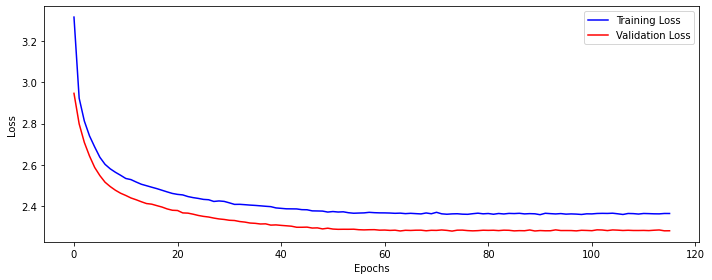

In [12]:
sbs = StepByStep(model, loss_fn, optimizer, scheduler)

sbs.set_loaders(train_loader, val_loader)
sbs.train_by_loss_change(1e-4)
#sbs.train_by_n_epochs(120)

sbs.plot_losses(ylog=False)

## 4. Generation

In [ ]:
# StepByStep.set_seed(96)

def vectorize_without_startend_toks(seq, vocab):
    seq = list(seq)
    vec = torch.zeros(len(seq), dtype=int)
    for i, item in enumerate(seq):
        vec[i] = vocab[item]
    return vec

def generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=5):

    def generate_sample(nationality):
        h = torch.tensor([nationality_vocab[nationality]])
        sample = surname_vocab.bgn_tok
        while sample[-1] not in (surname_vocab.end_tok, surname_vocab.pad_tok) and len(sample) < max_surname_size:
            x = vectorize_without_startend_toks(sample, surname_vocab).unsqueeze(0)
            y_hat = model(x, h)
            probs = F.softmax(y_hat[-1][-1], dim=-1).detach()
            next_char_i = torch.multinomial(probs, num_samples=1).item()
            next_char = surname_vocab.inverse[next_char_i]
            sample += next_char
            # if next_char in (surname_vocab.bgn_tok, surname_vocab.end_tok) :
            #     break
        return sample.strip(surname_vocab.bgn_tok + surname_vocab.end_tok + surname_vocab.pad_tok)
    
    model.eval()
    for nationality in nationality_vocab:
        print(nationality)
        for _ in range(num_samples):
            sample = generate_sample(nationality)
            print(f" - {sample}")


generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=5)

Arabic
 - Chawa
 - Magbyer
 - Qerose
 - Iskum
 - Nuiwrouy
Chinese
 - Atte
 - Du
 - Adwts
 - Zarer
 - Fan
Czech
 - Irimriz
 - Heavtak
 - Prardis
 - Hames
 - Dupda
Dutch
 - Rirc
 - Damhthasle
 - Swapidod
 - Skiyl
 - Stasnady
English
 - Hutclerl
 - Steoig
 - Horan
 - Mascher
 - Jouns
French
 - Mwary
 - Lanersoan
 - Sbolnmayson
 - Iskir
 - Jean
German
 - Alkus
 - Snordla
 - Kelwart
 - Houstister
 - Aonnay
Greek
 - Jeralanko
 - Hosithe
 - Kyatnetka
 - Mikiureb
 - Azrekertages
Irish
 - Nannidm
 - Dullotovt
 - Telr
 - Cintßor
 - Merta
Italian
 - Odaenno
 - Latzeo
 - Netes
 - Alpamelyl
 - Senatra
Japanese
 - Abrosuri
 - Umatoka
 - Fusaiun
 - Jakanu
 - Ikushao
Korean
 - Yan
 - Husull
 - Kam
 - Pibn
 - Wago
Polish
 - Bashnure
 - Jrakit
 - Howay
 - Gcjarilyn
 - Hanathraky
Portuguese
 - Sborien
 - Molae
 - Gac
 - Kacnabis
 - Andose
Russian
 - Naviertin
 - Damerta
 - Sovers
 - Enzr
 - Ralak
Scottish
 - Pmuwem
 - Busken
 - Laseson
 - Piislal
 - Shtory
Spanish
 - Vue
 - Anettaina
 - Atelr
 - Sesos
 -